In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Restructuring data to get self-loop details 

In [4]:
path = "C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project"

In [16]:
file_ = open(os.path.join(path,"data/json_data.json"))

In [18]:
data_dic = json.load(file_)

In [80]:
def restructure_data(data_dic):
    cols_df2 = data_dic['nodes'] +['selfloop']
    cols_df1 = ['car-id', 'car_type', 'enter_date', 'exit_date', 'total_in_time']
    df1 = pd.DataFrame(columns=cols_df1)
    df2 = pd.DataFrame(columns=cols_df2)

    for cartype in data_dic['data'].keys():
        for car in data_dic['data'][cartype]:
            col_1 = list(car.values())
            del col_1[1]
            df1.loc[len(df1)] = col_1
            col_2 =[0]*len(cols_df2)  
            for path in car['path_taken']:
                start = list(path.keys())[0].split(" ")[0]
                end = list(path.keys())[0].split(" ")[-1]
                if start == end:
                    col_2[cols_df2.index(end)] = list(path.values())[0]
                    col_2[-1] +=1  
            df2.loc[len(df2)] = col_2
    return pd.concat((df1,df2),axis=1)

In [81]:
df_new = restructure_data(data_dic)

In [166]:
df_new.to_csv(os.path.join(path,"data/selploop.csv"))

# Distribution plots

In [9]:
df_new = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)

C:\Users\18565\AppData\Local\Temp\ipykernel_18728\179364282.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)


In [10]:
df_new['car_type'] = df_new['car_type'].astype("str")

In [11]:
total_time_stayed_at_a_node = []
for colname in df_new.columns[5:14]:
    total_time_stayed_at_a_node.append(np.sum(df_new[colname]))

In [13]:
y = np.array(total_time_stayed_at_a_node)/(60)
x=  df_new.columns[5:14] 

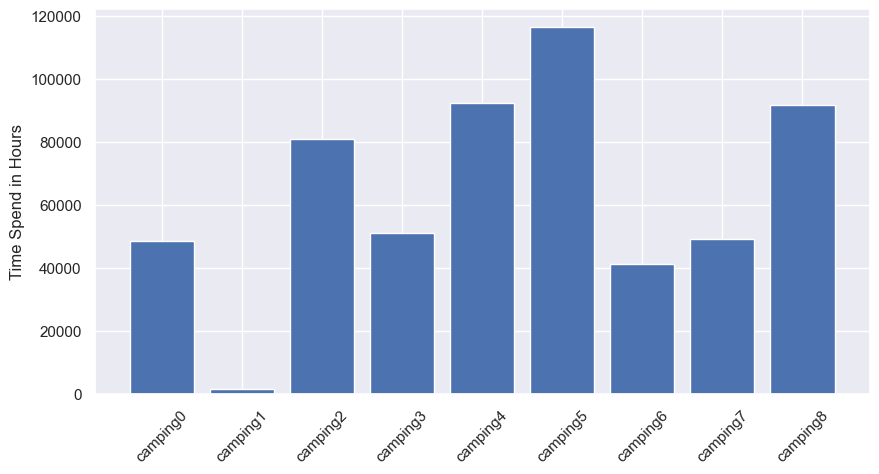

In [15]:
fig = plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.ylabel("Time Spend in Hours")
plt.xticks(rotation=45)
plt.show()

In [16]:
total_time_stayed_at_a_node = []
for colname in df_new.columns[14:-1]:
    total_time_stayed_at_a_node.append(np.sum(df_new[colname]))

In [17]:
x = df_new.columns[14:-1]
y = np.array(total_time_stayed_at_a_node)/60

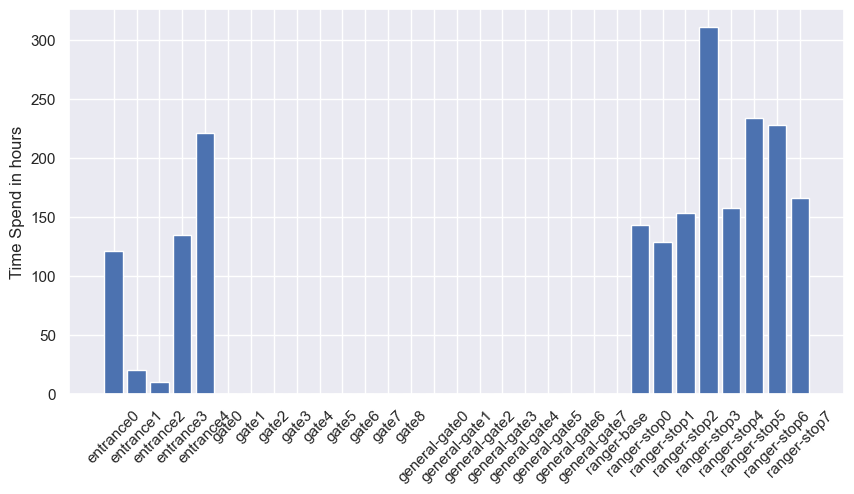

In [18]:
fig = plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.ylabel("Time Spend in hours")
plt.xticks(rotation=45)
plt.show()

# Heatmap of camping sites

* Values represent the average time spend at camping site.
* Color represents the number of cars that stayed at the camping sites

In [21]:
df = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)
df['car_type'] = df['car_type'].astype("str")

C:\Users\18565\AppData\Local\Temp\ipykernel_18728\3483449646.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)


In [22]:
df['enter_date'] = pd.to_datetime(df['enter_date'])

In [23]:
df['month_year'] = df['enter_date'].dt.strftime('%y-%m')

In [24]:
np.unique(df['month_year'])

array(['15-05', '15-06', '15-07', '15-08', '15-09', '15-10', '15-11',
       '15-12', '16-01', '16-02', '16-03', '16-04', '16-05'], dtype=object)

In [59]:
def get_heatmap_data(df,cat):
    colors = []
    values = []
    vmin = np.inf
    vmax = -np.inf
    for colname in df.columns:
        if cat in colname:
            heat_map_values = df.pivot_table(index="month_year",columns="car_type",
                                  values=colname, aggfunc='sum', fill_value=0)
            heat_map_colors = df.pivot_table(index="month_year",columns="car_type",
                                  values=colname, aggfunc='nunique', fill_value=0)
            heat_map_colors.replace(1,0,inplace=True)
            heat_map_avg_values = heat_map_values/heat_map_colors
            heat_map_avg_values.fillna(0,inplace=True)
            if np.max(heat_map_colors) > vmax:
                vmax = np.max(heat_map_colors)
            if np.min(heat_map_colors) < vmin:
                vmin = np.min(heat_map_colors)
            colors.append(heat_map_colors)
            values.append(heat_map_avg_values)
    return colors,values/(np.ones_like(values)*60),vmin,vmax
            
            
            
    

In [60]:
colors,values,vmin,vmax = get_heatmap_data(df,'camping')

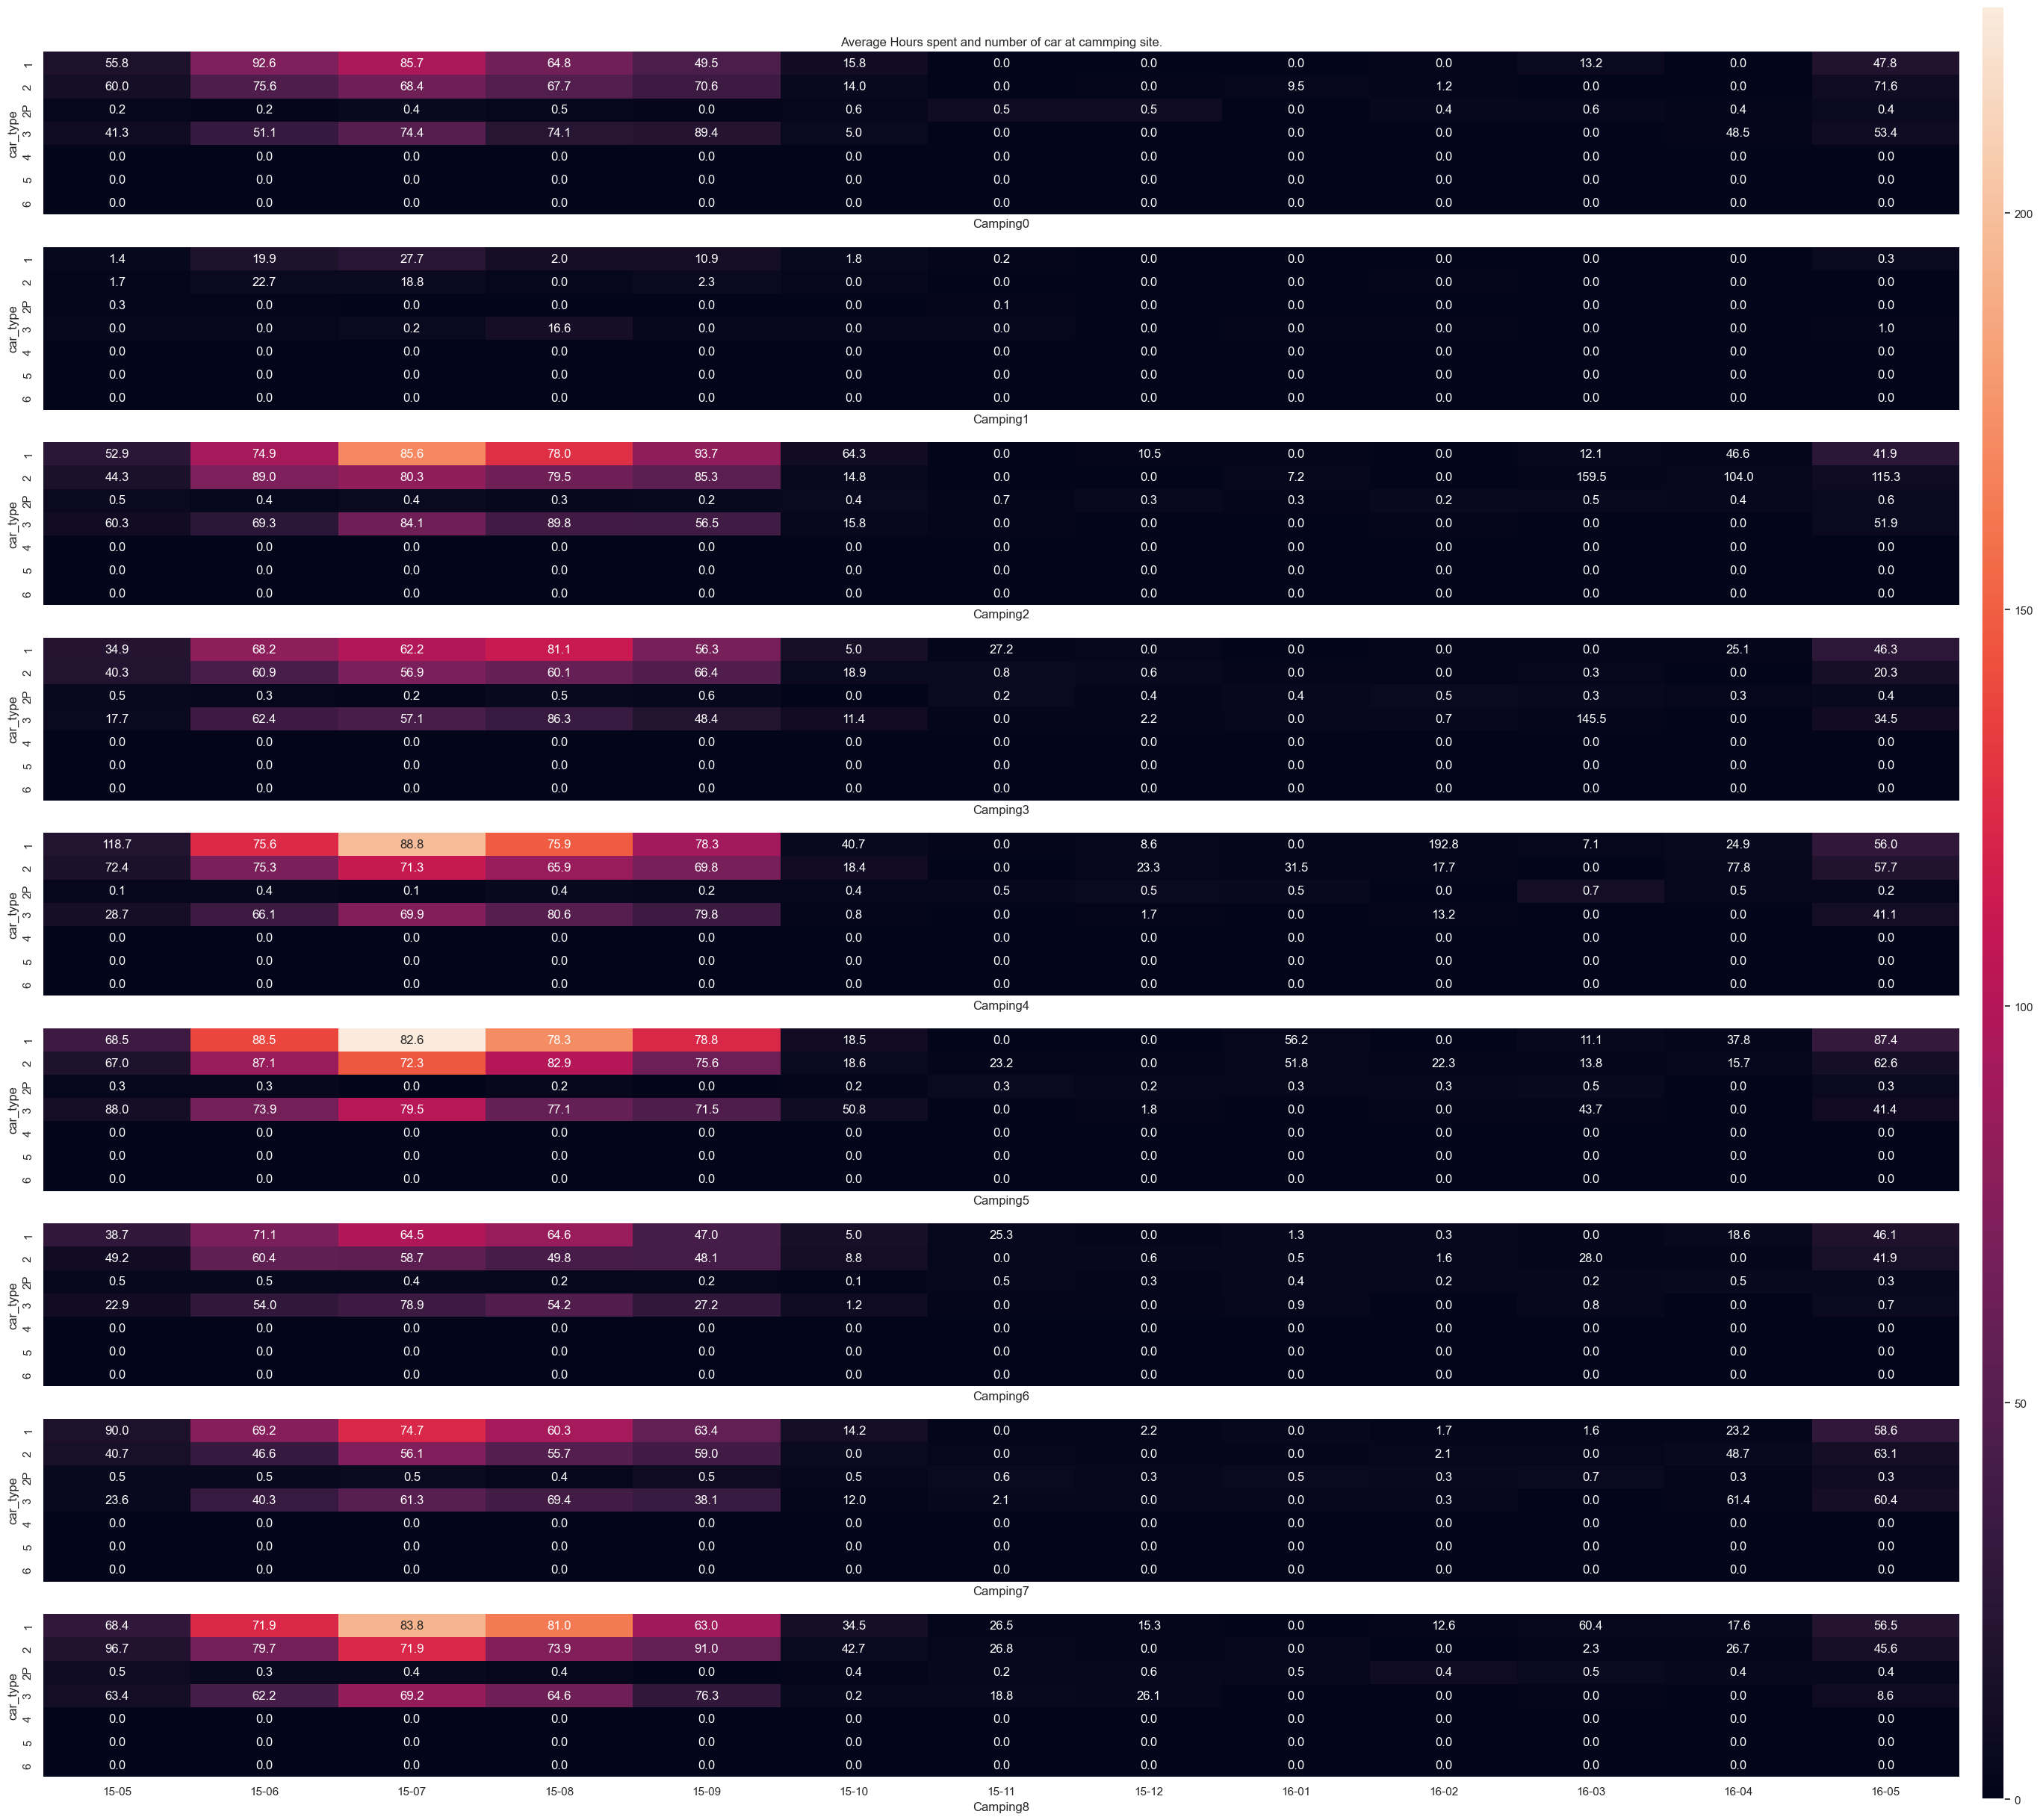

In [61]:
fig, axs = plt.subplots(len(colors),1,figsize=(30,30))
count = 0
for ax, color, value in zip(axs,colors,values):
    sns.heatmap(color.T,annot=value.T,fmt='.1f',ax=ax, vmin=vmin,vmax=vmax,cbar=False)
    if count <8:
        ax.xaxis.set_tick_params(labelbottom=False,which='both')
    ax.set(xlabel="Camping"+str(count))
    count+=1
fig.subplots_adjust(right=0.98)
cbar_ax = fig.add_axes([0.99, 0.1, 0.01, 0.8])
fig.colorbar(ax.collections[0],cax=cbar_ax)
axs[0].set_title("Average Hours spent and number of car at cammping site.")

plt.show()

# Dividing into morning, midday, evening,night, midnight, dawn

Morning $\implies (6,10]$

Midday $\implies (10,14] $

Evening $ \implies (14,18] $

Night $ \implies (18,22]$

Midday $ \implies (22,2]$

Dawn $ \implies (2,6]$

Weekend $\implies$ Sat, Sun.

Weekdays $\implies$ Mon, Tue, Wed, Thu, Fri.


In [63]:
df = pd.read_csv(os.path.join(path,"data\Lekagul Sensor Data.csv"))

In [66]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp',inplace=True)

In [71]:
from datetime import time

In [73]:
time(6)

datetime.time(6, 0)

In [80]:
time(23,59,59) <= time(0)

False

In [76]:
time(2) < df.index[0].time()

False

In [138]:
time_of_day = []
day_of_week = []
for i in df.index:
   if (time(6) < i.time() <=time(10)):
       time_of_day.append( "Morning" )
   elif (time(10) < i.time() <=time(14 )):
       time_of_day.append("Midday")
   elif (time(14) < i.time() <=time(18)):
       time_of_day.append("Evening")
   elif (time(18) < i.time() <=time(22)):
       time_of_day.append("Night")
   elif ((time(22) < i.time() <= time(23,59,59)) or (time(0) <= i.time() <= time(2))):
       time_of_day.append("Midnight")
   elif (time(2) < i.time() <=time(6)):
       time_of_day.append("Dawn")
   else:
       time_of_day.append("NA")
   if i.weekday() <5:
        day_of_week.append("Weekday")
   else:
        day_of_week.append("Weekend")

In [139]:
df["time_of_day"]= time_of_day
df['day_of_week'] = day_of_week

In [146]:
time_of_day_dummies = pd.get_dummies(df['time_of_day'],dtype=int)
day_of_week_dummies = pd.get_dummies(df['day_of_week'],dtype=int)

Index(['car-id', 'car-type', 'gate-name'], dtype='object')

In [151]:
new_df = pd.concat((df[df.columns[:3]],time_of_day_dummies,day_of_week_dummies),axis=1)

In [157]:
x = new_df.describe()

In [179]:
ax.flat

In [180]:
len(np.unique(new_df['car-type']))

7

In [186]:
values

car-id       20154301124328-262
car-type                      4
gate-name         general-gate1
Dawn                          0
Evening                       0
Midday                        0
Midnight                      1
Morning                       0
Night                         0
Name: 2015-05-01 01:03:48, dtype: object

In [189]:
cols

Index(['Dawn', 'Evening', 'Midday', 'Midnight', 'Morning', 'Night'], dtype='object')

Text(0.5, 1.0, 'Total')

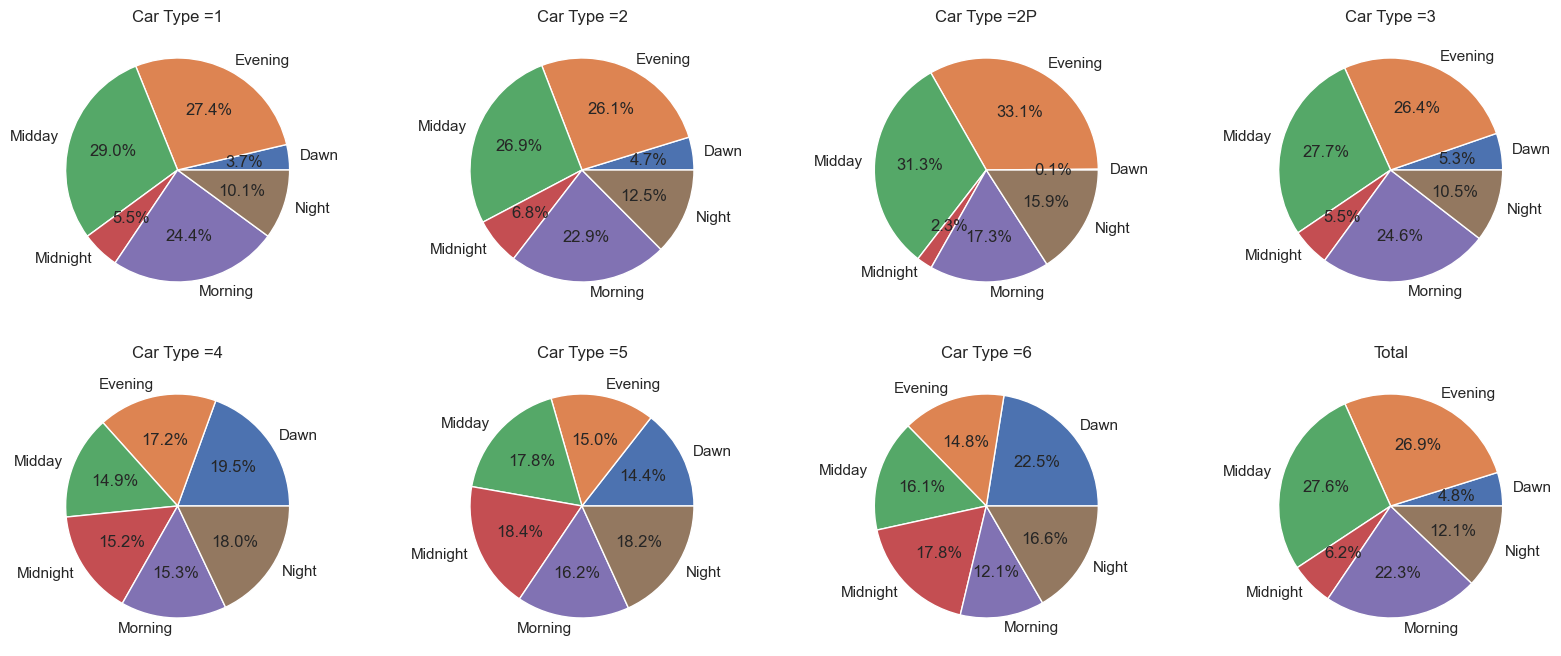

In [198]:
fig, axes = plt.subplots(2,4,figsize =(20,8))

for ax , cartype in zip(axes.flat,np.unique(new_df['car-type'])):
    cartype_df = new_df[new_df['car-type']==cartype].describe()
    cols = cartype_df.columns[:-2]
    values = cartype_df.iloc[1][cols]
    ax.pie(values, labels=cols, autopct='%1.1f%%')
    ax.set_title("Car Type =" +cartype)
cols = new_df.columns[3:-2]
values = new_df.describe().iloc[1][cols]
axes[1][3].pie(values,labels=cols, autopct='%1.1f%%')
axes[1][3].set_title("Total")

Text(0.5, 1.0, 'Total')

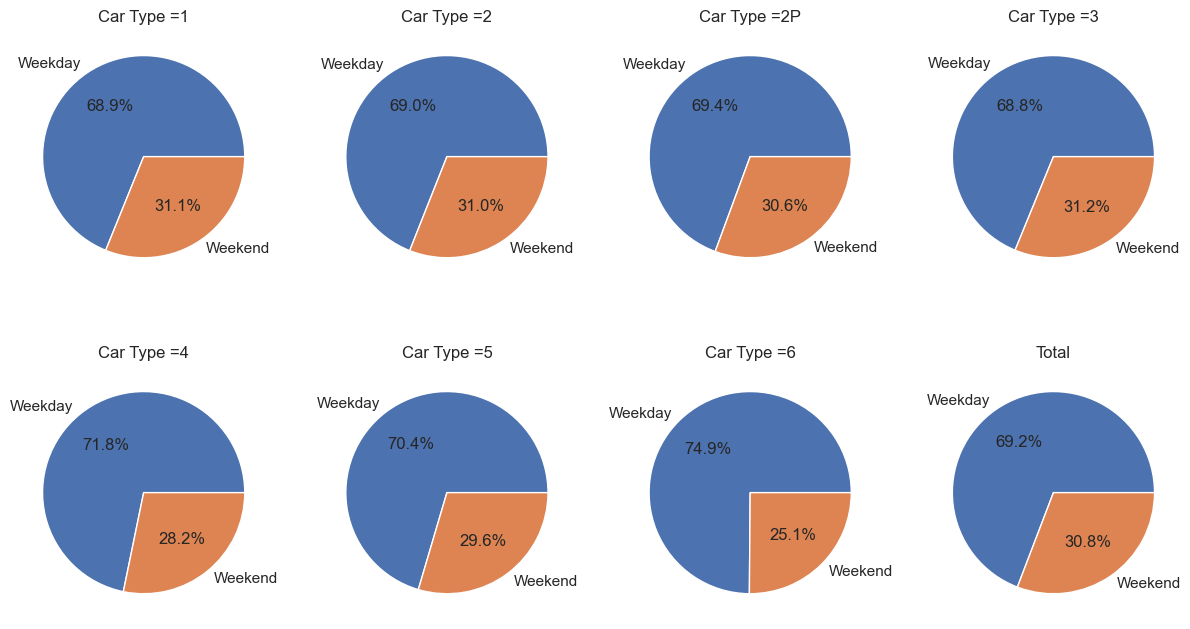

In [196]:
fig, axes = plt.subplots(2,4,figsize =(15,8))

for ax , cartype in zip(axes.flat,np.unique(new_df['car-type'])):
    cartype_df = new_df[new_df['car-type']==cartype].describe()
    cols = cartype_df.columns[-2:]
    values = cartype_df.iloc[1][cols]
    ax.pie(values, labels=cols, autopct='%1.1f%%')
    ax.set_title("Car Type =" +cartype)
cols = new_df.columns[-2:]
values = new_df.describe().iloc[1][cols]
axes[1][3].pie(values,labels=cols, autopct='%1.1f%%')
axes[1][3].set_title("Total")

In [163]:
np.sum(x.iloc[1][new_df.columns[3:-2]])

1.0

In [159]:
x

,Dawn,Evening,Midday,Midnight,Morning,Night,Weekday,Weekend
count,171477.000000,171477.000000,171477.000000,171477.000000,171477.000000,171477.000000,171477.000000,171477.000000
mean,0.048450,0.268532,0.275833,0.062487,0.223482,0.121217,0.691965,0.308035
std,0.214715,0.443197,0.446934,0.242038,0.416580,0.326381,0.461683,0.461683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
